**<span style="font-size: 24px;">Python Libraries**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**<span style="font-size: 24px;">Read and analyse data**

In [22]:
# Read our data
df = pd.read_csv("data.csv")

Perform basic data analysis


In [21]:
# Visualise the data
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [23]:
# Check usefull information such as total entries, cols and dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

From the previous tables we can see that column **diagnosis** is the target label, columns **id** and **Unnamed: 32** seem irrelevant for classification and all features have different scales.

In [28]:
# We can drop the "id" and "Unnamed: 32" cols since they do not affect the diagnosis prediction
df.drop(["id", "Unnamed: 32"], axis=1, inplace=True)
df.shape

(569, 31)

In [40]:
# Separate features from labels
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

Let's analyse our target label

Malignant: 212
Benign: 357


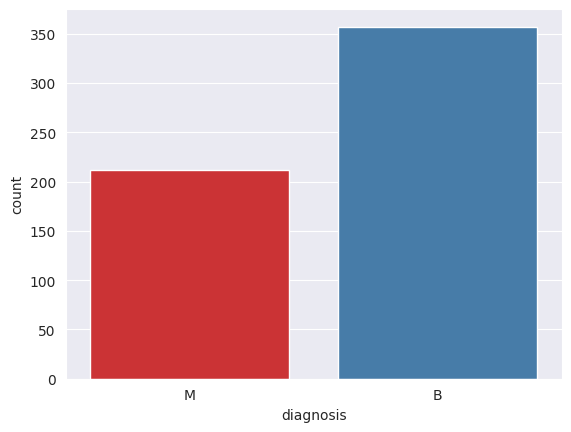

In [41]:
# Check the diagnosis classes and their distribution
_, label_distribution = np.unique(y, return_counts=True)
print(f"Malignant: {label_distribution[1]}")
print(f"Benign: {label_distribution[0]}")
sns.countplot(x=y, palette="Set1");

In [42]:
M_proportion = label_distribution[0] / (label_distribution[1] + label_distribution[0])
B_proportion = label_distribution[1] / (label_distribution[1] + label_distribution[0])
print(f"Malignant Proportion: {M_proportion:.2f}")
print(f"Benign Proportion: {B_proportion:.2f}")

Malignant Proportion: 0.63
Benign Proportion: 0.37


While the dataset has some degree of imbalance (0.63 vs 0.37), it is not extremely imbalanced. Metrics such as accuracy and recall are still relevant to evaluate the model.

Now let's analyse our features

In [44]:
# Analyse features
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


To further inspect the data we can produce some box plot visualizations and gain insights about correlations between features and label. But first we need to standardize the features due to their different scales.

**<span style="font-size: 24px;">Data Processing**

In [39]:
# Encode diagnosis to numerical values where M = 1 and B = 0
def diagnosis_encoder(value):
    if value == "M": return 1
    else: return 0
    
df["diagnosis"] = df["diagnosis"].apply(diagnosis_encoder)

diagnosis
0    357
1    212
Name: count, dtype: int64

In [51]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
# Train and evaluate KNeighborsClassifier with different k values using cross-validation
neighbors = []
scores = []

for k in range(1, 31, 2):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=10, scoring="recall") # 10 folds
    scores.append(score.mean())

Best k value is 7 with recall 0.9294117647058823


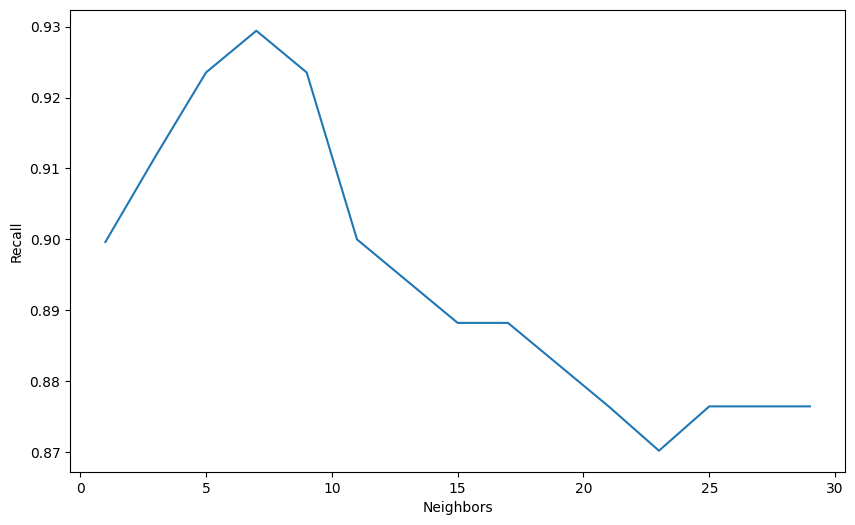

In [97]:
# Find the best k value
best_score_index = scores.index(max(scores))
print(f"Best k value is {neighbors[best_score_index]} with recall {scores[best_score_index]}")

plt.figure(figsize=(10, 6))
plt.plot(neighbors, scores)
plt.xlabel("Neighbors")
plt.ylabel("Recall")
plt.show()

In [102]:
# Evaluate model with k=7 using classification report
knn = KNeighborsClassifier(n_neighbors=neighbors[best_score_index])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"])
print(report)

              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        71
   Malignant       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [ ]:
#TODO PCA